In [1]:
!pip install torch
!pip install transformers
!pip install emoji
!pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 7.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
file_path = "/content/drive/MyDrive/23-2 창의적종합설계 /data/요약 추가  데이터/news_sm_요약추가.csv"

In [6]:
# pandas로 CSV 파일 읽기
sm_df = pd.read_csv(file_path)
sm_df.head()

,제목,작성일시,본문,요약
0,K팝 가수 깨알 정보까지 한눈에 제공,2023-02-01,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...
1,올해 신인그룹 속속 데뷔 .기대 커진 엔터주 동반강세,2023-02-01,"하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ...","하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ..."
2,뉴진스는 좋지만 배당은 아쉽다...시총 7.7조 하이브 주주환원 방안에는 침묵,2023-02-02,SM엔터테인먼트 지난해 첫 배당 실시 그룹 방탄소년단 공백에도 하이브의 주가 상승세...,주가는 작년 10월 저점 대비 75퍼센트 올랐다.증권가에서도 신인 그룹 제작원가 반...
3,SM엔터가 내놓고 SM엔터가 흔드는 묘한 M A,2023-02-02,"매물로 나온지 한참 흐른 SM엔터군불만 뗄 뿐 거래 이어지지 않아 카카오엔터, CJ...",이수만 SM엔터테인먼트 회장의 지분을 어떤 기업이 인수할 지를 두고 설이 분분하다....
4,"SM엔터, SM 3.0 기대감에 사상 첫 9만 원 돌파",2023-02-03,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base")

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch

sm_df = sm_df.dropna(subset=['요약'])

titles = sm_df['요약'].astype(str).tolist()

# 감정분석 수행
predictions = []
probabilities = []  # 확률을 저장할 리스트

for title in titles:
    inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # softmax 확률 계산
        probs = torch.softmax(logits, dim=-1)[0]  # 첫 번째 차원에서 softmax 적용

        pred = torch.argmax(logits, dim=1).item()
        predictions.append(pred)

        # 최대 확률값만 저장 (예측된 클래스의 확률)
        probabilities.append(probs[pred].item())

sm_df['요약_감정'] = predictions
sm_df['요약_확률'] = probabilities  # 데이터프레임에 확률 열 추가

In [12]:
sm_new_df = sm_df.groupby('작성일시')['요약_확률'].mean().reset_index()
sm_new_df

,작성일시,요약_확률
0,2023-02-01,0.554534
1,2023-02-02,0.555544
2,2023-02-03,0.553743
3,2023-02-04,0.553297
4,2023-02-05,0.551205
...,...,...
162,2023-07-26,0.555237
163,2023-07-27,0.554516
164,2023-07-28,0.552987
165,2023-07-29,0.553706


In [13]:
value_counts = sm_df['요약_감정'].value_counts()
print(value_counts)

1    2186
Name: 요약_감정, dtype: int64


In [16]:
sm_df['요약_확률'] = sm_df.apply(lambda x: 1 - x['요약_확률'] if x['요약_감정'] == 0 else x['요약_확률'], axis=1)
sm_df

,제목,작성일시,본문,요약,요약_감정,요약_확률
0,K팝 가수 깨알 정보까지 한눈에 제공,2023-02-01,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...,1,0.554250
1,올해 신인그룹 속속 데뷔 .기대 커진 엔터주 동반강세,2023-02-01,"하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ...","하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ...",1,0.554817
2,뉴진스는 좋지만 배당은 아쉽다...시총 7.7조 하이브 주주환원 방안에는 침묵,2023-02-02,SM엔터테인먼트 지난해 첫 배당 실시 그룹 방탄소년단 공백에도 하이브의 주가 상승세...,주가는 작년 10월 저점 대비 75퍼센트 올랐다.증권가에서도 신인 그룹 제작원가 반...,1,0.555457
3,SM엔터가 내놓고 SM엔터가 흔드는 묘한 M A,2023-02-02,"매물로 나온지 한참 흐른 SM엔터군불만 뗄 뿐 거래 이어지지 않아 카카오엔터, CJ...",이수만 SM엔터테인먼트 회장의 지분을 어떤 기업이 인수할 지를 두고 설이 분분하다....,1,0.555632
4,"SM엔터, SM 3.0 기대감에 사상 첫 9만 원 돌파",2023-02-03,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...,1,0.553065
...,...,...,...,...,...,...
2181,뒤숭숭한 카카오...항의서한 받은 김범수 창업주,2023-07-27,"김범수 카카오 미래이니셔티브 센터장.카카오가 안팎으로 뒤숭숭하면서, 입지가 흔들리...","김범수 카카오 미래이니셔티브 센터장.카카오가 안팎으로 뒤숭숭하면서, 입지가 흔들리...",1,0.555424
2182,17만원에서 4만원대.연 이은 악재에 바람 잘 날 없는 카카오,2023-07-28,시세조종 의혹 계열사 실적 부진 등 악재수사 결과 따라 주가 추가 하락 불가피2분기...,시세조종 의혹 계열사 실적 부진 등 악재수사 결과 따라 주가 추가 하락 불가피2분기...,1,0.552987
2183,그가 없었다면 지금의 K팝도 없다,2023-07-29,이수만 연구 이수만 연구 전영선 배정원 황지영 박건 지음 커뮤니케이션북스 현재 한...,이수만 연구 이수만 연구 전영선 배정원 황지영 박건 지음 커뮤니케이션북스 현재 한국...,1,0.553706
2184,"실적과 주가는 반 토막, 직원들은 단체행동.사면초가 카카오",2023-07-31,네이버와 더불어 한국 IT 산업의 양강으로 꼽히는 카카오가 흔들린다. 실적과 주가는...,실적과 주가는 지난해 대비 반 토막 나며 급감했다.\n그야말로 사면초가 에 빠진 상...,1,0.556701


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

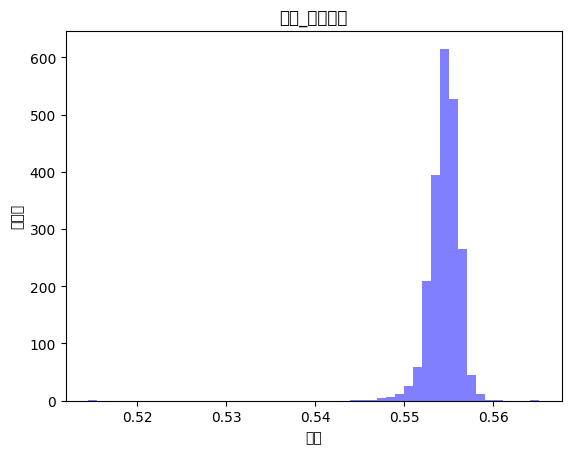

In [17]:
import matplotlib.pyplot as plt

plt.hist(sm_df['요약_확률'], bins=50, alpha=0.5, color='blue')

plt.title('요약_감정확률')
plt.xlabel('확률')
plt.ylabel('빈도수')

plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sm_df['요약_보정_확률'] = scaler.fit_transform(sm_df['요약_확률'].values.reshape(-1, 1))

sm_df.head()

,제목,작성일시,본문,요약,요약_감정,요약_확률,요약_보정_확률
0,K팝 가수 깨알 정보까지 한눈에 제공,2023-02-01,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...,김홍기 스페이스오디티 대표팬덤 플랫폼 블립 운영 K팝 스타에 대해 미주알고주알 깨알...,1,0.554250,0.784834
1,올해 신인그룹 속속 데뷔 .기대 커진 엔터주 동반강세,2023-02-01,"하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ...","하이브, 걸그룹 뉴진스 돌풍방탄소년단 공백 거뜬히 메워JYP엔터, 모두 4팀 출격 ...",1,0.554817,0.796013
2,뉴진스는 좋지만 배당은 아쉽다...시총 7.7조 하이브 주주환원 방안에는 침묵,2023-02-02,SM엔터테인먼트 지난해 첫 배당 실시 그룹 방탄소년단 공백에도 하이브의 주가 상승세...,주가는 작년 10월 저점 대비 75퍼센트 올랐다.증권가에서도 신인 그룹 제작원가 반...,1,0.555457,0.808636
3,SM엔터가 내놓고 SM엔터가 흔드는 묘한 M A,2023-02-02,"매물로 나온지 한참 흐른 SM엔터군불만 뗄 뿐 거래 이어지지 않아 카카오엔터, CJ...",이수만 SM엔터테인먼트 회장의 지분을 어떤 기업이 인수할 지를 두고 설이 분분하다....,1,0.555632,0.812091
4,"SM엔터, SM 3.0 기대감에 사상 첫 9만 원 돌파",2023-02-03,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...,전 거래일 대비 2.13퍼센트상승 3일 SM엔터테인먼트는 전 거래일 대비 2.13퍼...,1,0.553065,0.761451


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

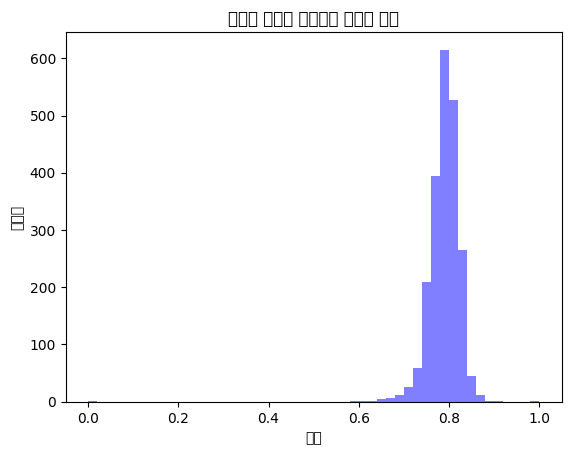

In [23]:
# 히스토그램 생성
plt.hist(sm_df['요약_보정_확률'], bins=50, alpha=0.5, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('보정된 제목의 감정분석 확률의 분포')
plt.xlabel('확률')
plt.ylabel('빈도수')

# 그래프 보여주기
plt.show()

In [26]:
import pandas as pd
file_path = "/content/drive/MyDrive/23-2 창의적종합설계 /data/요약 추가  데이터/news_에코프로_요약추가.csv"

# pandas로 CSV 파일 읽기
eco_df = pd.read_csv(file_path)
eco_df.head()

,제목,작성일시,본문,요약
0,반도체만 바라보는 천수답 수출 . 하반기엔 보릿고개 넘을까,2023-02-01,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...
1,내일 새벽 나올 FOMC 회의 결과.파월은 어떤 입장 내 놓을까,2023-02-01,제롬 파월 미국 연방준비제도 이사회 의장 AP 뉴시스코스피가 이틀 간의 약세를 멈...,금융 환경의 완화가 더 가속화되지 않도록 제롬 파월 연준 이사회 의장이 매파적 입장...
2,"코스피, 외인 매수에 반등.2450선 턱밑",2023-02-01,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다. 코스피가 상승 ...,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다.\n1일 코스피는...
3,"코스피, FOMC 앞두고 1퍼센트 상승 마감.외국인 순매수 전환",2023-02-01,"전날 하락한 삼성전자 SK하이닉스 반등 코스피, 2,440대로 올라서 상승 출발. ...","지수는 전장보다 20.95포인트 오른 2,446.03로 출발했다.\n지수는 전장보다..."
4,삼성 2.3조 SK 0.4조.날아간 반도체 혜택,2023-02-01,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼...,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼성...


In [28]:
import torch

eco_df = eco_df.dropna(subset=['요약'])

titles = eco_df['요약'].astype(str).tolist()

predictions = []
probabilities = []  # 확률을 저장할 리스트

for title in titles:
    inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # softmax 확률 계산
        probs = torch.softmax(logits, dim=-1)[0]  # 첫 번째 차원에서 softmax 적용

        pred = torch.argmax(logits, dim=1).item()
        predictions.append(pred)

        # 최대 확률값만 저장 (예측된 클래스의 확률)
        probabilities.append(probs[pred].item())

eco_df['요약_감정'] = predictions
eco_df['요약_확률'] = probabilities  # 데이터프레임에 확률 열 추가

eco_new_df = eco_df.groupby('작성일시')['요약_확률'].mean().reset_index()
eco_new_df

,작성일시,요약_확률
0,2023-02-01,0.513657
1,2023-02-02,0.514030
2,2023-02-03,0.514182
3,2023-02-04,0.512478
4,2023-02-05,0.514881
...,...,...
176,2023-07-27,0.513939
177,2023-07-28,0.513893
178,2023-07-29,0.514246
179,2023-07-30,0.512958


In [29]:
value_counts = eco_df['요약_감정'].value_counts()
print(value_counts)

1    19408
Name: 요약_감정, dtype: int64


In [30]:
eco_df['요약_확률'] = eco_df.apply(lambda x: 1 - x['요약_확률'] if x['요약_감정'] == 0 else x['요약_확률'], axis=1)
eco_df

,제목,작성일시,본문,요약,요약_감정,요약_확률
0,반도체만 바라보는 천수답 수출 . 하반기엔 보릿고개 넘을까,2023-02-01,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...,1,0.508941
1,내일 새벽 나올 FOMC 회의 결과.파월은 어떤 입장 내 놓을까,2023-02-01,제롬 파월 미국 연방준비제도 이사회 의장 AP 뉴시스코스피가 이틀 간의 약세를 멈...,금융 환경의 완화가 더 가속화되지 않도록 제롬 파월 연준 이사회 의장이 매파적 입장...,1,0.509202
2,"코스피, 외인 매수에 반등.2450선 턱밑",2023-02-01,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다. 코스피가 상승 ...,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다.\n1일 코스피는...,1,0.512809
3,"코스피, FOMC 앞두고 1퍼센트 상승 마감.외국인 순매수 전환",2023-02-01,"전날 하락한 삼성전자 SK하이닉스 반등 코스피, 2,440대로 올라서 상승 출발. ...","지수는 전장보다 20.95포인트 오른 2,446.03로 출발했다.\n지수는 전장보다...",1,0.517970
4,삼성 2.3조 SK 0.4조.날아간 반도체 혜택,2023-02-01,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼...,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼성...,1,0.519685
...,...,...,...,...,...,...
19403,대신 이차전지 반등은 데드 캣 바운스.후폭풍 경계,2023-07-31,외인 수급 주도권 가져갈지 관건 대신증권 대신증권은 31일 이차전지 관련주의 급락 ...,외인 수급 주도권 가져갈지 관건 대신증권 대신증권은 31일 이차전지 관련주의 급락 ...,1,0.512591
19404,"코스피, 훈풍 개인 사자 상승 마감.이차전지 강세 여전",2023-07-31,코스닥 시가총액 상위 10개 종목 모두 빨간불 31일 코스피는 전날보다 24.26포...,코스닥 시가총액 상위 10개 종목 모두 빨간불 31일 코스피는 전날보다 24.26포...,1,0.515646
19405,북미 인프라 수혜 고공행진,2023-07-31,실적호조 효성 상한가LS일렉 변압기 매출호조공급망에서 중국 의존도를 줄이고 공급처를...,"특히 미국이 디리스킹을 인프라 투자 및 일자리법 , 인플레이션 감축법 과 연계해 추...",1,0.514326
19406,"웰바이오텍, 리튬 원광 1차분 선적. 고부가가치 사업 확대",2023-07-31,웰바이오텍이 이차전지의 필수재인 리튬 사업을 본격적으로 시작한다. 짐바브웨에서 채...,짐바브웨에서 채굴된 리튬 원광 1차분 물량을 싣고 중국을 향해 출발한다.31일 웰바...,1,0.511614


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

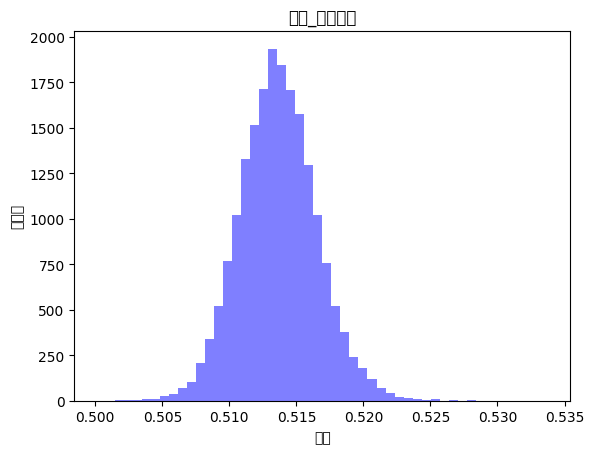

In [31]:
import matplotlib.pyplot as plt

plt.hist(eco_df['요약_확률'], bins=50, alpha=0.5, color='blue')

plt.title('요약_감정확률')
plt.xlabel('확률')
plt.ylabel('빈도수')

plt.show()

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
eco_df['요약_보정_확률'] = scaler.fit_transform(eco_df['요약_확률'].values.reshape(-1, 1))

eco_df.head()

,제목,작성일시,본문,요약,요약_감정,요약_확률,요약_보정_확률
0,반도체만 바라보는 천수답 수출 . 하반기엔 보릿고개 넘을까,2023-02-01,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...,반도체수출액 108억에서60억 D램값도 역대최저 호재 실종 수출액 31퍼센트 쪼그라...,1,0.508941,0.262153
1,내일 새벽 나올 FOMC 회의 결과.파월은 어떤 입장 내 놓을까,2023-02-01,제롬 파월 미국 연방준비제도 이사회 의장 AP 뉴시스코스피가 이틀 간의 약세를 멈...,금융 환경의 완화가 더 가속화되지 않도록 제롬 파월 연준 이사회 의장이 매파적 입장...,1,0.509202,0.269923
2,"코스피, 외인 매수에 반등.2450선 턱밑",2023-02-01,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다. 코스피가 상승 ...,코스닥도 1.4퍼센트상승코스피지수가 외국인 매수세에 상승 마감했다.\n1일 코스피는...,1,0.512809,0.377151
3,"코스피, FOMC 앞두고 1퍼센트 상승 마감.외국인 순매수 전환",2023-02-01,"전날 하락한 삼성전자 SK하이닉스 반등 코스피, 2,440대로 올라서 상승 출발. ...","지수는 전장보다 20.95포인트 오른 2,446.03로 출발했다.\n지수는 전장보다...",1,0.517970,0.530614
4,삼성 2.3조 SK 0.4조.날아간 반도체 혜택,2023-02-01,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼...,법인세 최저한세 에 발목잡힌 투자 세액공제최대 25퍼센트 공제율 적용때 실효세율삼성...,1,0.519685,0.581613


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

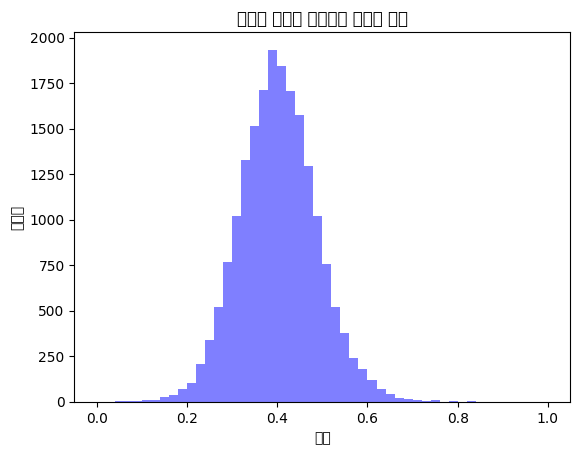

In [36]:
# 히스토그램 생성
plt.hist(eco_df['요약_보정_확률'], bins=50, alpha=0.5, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('보정된 제목의 감정분석 확률의 분포')
plt.xlabel('확률')
plt.ylabel('빈도수')

# 그래프 보여주기
plt.show()

In [34]:
eco_df.to_csv('/content/drive/MyDrive/23-2 창의적종합설계 /data/eco_news_all.csv', index=False)

In [37]:
eco_df.to_csv('/content/drive/MyDrive/23-2 창의적종합설계 /data/eco_news_all_index.csv', index = True)

In [38]:
sm_df.to_csv('/content/drive/MyDrive/23-2 창의적종합설계 /data/sm_news_all.csv', index=False)

In [39]:
sm_df.to_csv('/content/drive/MyDrive/23-2 창의적종합설계 /data/sm_news_all_index.csv', index=True)

In [ ]:
import pandas as pd
file_path = "/content/drive/MyDrive/news_july_preprocessed_eco.csv"

# pandas로 CSV 파일 읽기
df = pd.read_csv(file_path)
df = df.drop(columns=['Unnamed: 0'])
df.head()

,제목,게시일,본문
0,만원 임박한 에코프로 다음 황제주 후보는 누구,2023-07-15,삼성바이오로직스 목표주가 만원 가장 유력 일 서울 중구 하나은행 딜링룸 직원 모니터...
1,에코프로도 당했다 미즈호 등 불법 공매도 무더기 적발,2023-07-14,주식 빌리지 않고 선매도 하는 무차입 공매도 혐의 회사측 고의 없었다 착오였다 과징...
2,에코프로 무한질주에 증권가 곤혹 에코프로비엠은 더 올라,2023-07-14,지난 일 오후 서울 종로구 연합인포맥스 스크린에 에코프로 차트가 띄워져 있다 코스...
3,하림지주 에코프로 등 상반기 주식관련사채 행사액 조 억,2023-07-14,한국예탁결제원은 올해 상반기 전환사채 교환사채 신주인수권부사채 등 주식관련사채 행...
4,에코프로 포항에 조 투자 양극재 허브 구축,2023-07-13,에코프로가 포항시 남구 블루밸리 국가산업단지에 양극소재 생태계 조성을 위해 조원을...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

df = df.dropna(subset=['제목'])

titles = df['제목'].astype(str).tolist()

# 감정분석 수행
predictions = []
probabilities = []  # 확률을 저장할 리스트

for title in titles:
    inputs = tokenizer(title, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # softmax 확률 계산
        probs = torch.softmax(logits, dim=-1)[0]  # 첫 번째 차원에서 softmax 적용

        pred = torch.argmax(logits, dim=1).item()
        predictions.append(pred)

        # 최대 확률값만 저장 (예측된 클래스의 확률)
        probabilities.append(probs[pred].item())

df['제목_감정분석결과'] = predictions
df['제목_감정분석확률'] = probabilities  # 데이터프레임에 확률 열 추가

In [ ]:
df

,제목,게시일,본문,제목_감정분석결과,제목_감정분석확률,제목_보정된_감정분석확률,감정레이블
0,만원 임박한 에코프로 다음 황제주 후보는 누구,2023-07-15,삼성바이오로직스 목표주가 만원 가장 유력 일 서울 중구 하나은행 딜링룸 직원 모니터...,0,0.506310,0.374973,중립
1,에코프로도 당했다 미즈호 등 불법 공매도 무더기 적발,2023-07-14,주식 빌리지 않고 선매도 하는 무차입 공매도 혐의 회사측 고의 없었다 착오였다 과징...,0,0.507448,0.358136,중립
2,에코프로 무한질주에 증권가 곤혹 에코프로비엠은 더 올라,2023-07-14,지난 일 오후 서울 종로구 연합인포맥스 스크린에 에코프로 차트가 띄워져 있다 코스...,0,0.512070,0.289767,약한 부정
3,하림지주 에코프로 등 상반기 주식관련사채 행사액 조 억,2023-07-14,한국예탁결제원은 올해 상반기 전환사채 교환사채 신주인수권부사채 등 주식관련사채 행...,0,0.508581,0.341372,약한 부정
4,에코프로 포항에 조 투자 양극재 허브 구축,2023-07-13,에코프로가 포항시 남구 블루밸리 국가산업단지에 양극소재 생태계 조성을 위해 조원을...,1,0.509288,0.605719,중립
...,...,...,...,...,...,...,...
4608,코뱃,2023-07-19,코뱃 은 스마트 기업 리더 부문으로 국회 차산업혁명포럼 대표의원상을 수상했다 코뱃은...,1,0.532725,0.952439,강한 긍정
4609,안보 인도 재정 지원 재건 협력 대 패키지 약속,2023-07-17,우크라 평화 이니셔티브 추진지난해보다 늘어난 군수물자 제공 억 만달러 인도적 지원...,0,0.504664,0.399323,중립
4610,보건의료노조가 요구하는 것,2023-07-18,지난 한 주간 발생했던 주목할 만한 이슈를 기자들의 시선으로 짧고 가볍게 정리한 코...,0,0.503082,0.422724,중립
4611,매니저의 종목,2023-07-20,해성디에스는 반도체용 패키지 서브스트레이트와 리드프레임을 전문적으로 제조하는 기업이...,1,0.527020,0.868046,강한 긍정


In [ ]:
new_df = df.groupby('게시일')['제목_감정분석결과'].mean().reset_index()
new_df

,게시일,제목_감정분석결과
0,2023-07-01,0.315789
1,2023-07-02,0.269231
2,2023-07-03,0.405530
3,2023-07-04,0.342697
4,2023-07-05,0.412162
5,2023-07-06,0.342282
6,2023-07-07,0.354839
7,2023-07-08,0.285714
8,2023-07-09,0.408163
9,2023-07-10,0.401606


In [ ]:
value_counts = df['제목_감정분석결과'].value_counts()
print(value_counts)

0    3008
1    1605
Name: 제목_감정분석결과, dtype: int64


In [ ]:
df['제목_감정분석확률'] = df.apply(lambda x: 1 - x['제목_감정분석확률'] if x['제목_감정분석결과'] == 0 else x['제목_감정분석확률'], axis=1)
df

,제목,게시일,본문,제목_감정분석결과,제목_감정분석확률,제목_보정된_감정분석확률,감정레이블
0,만원 임박한 에코프로 다음 황제주 후보는 누구,2023-07-15,삼성바이오로직스 목표주가 만원 가장 유력 일 서울 중구 하나은행 딜링룸 직원 모니터...,0,0.493690,0.374973,중립
1,에코프로도 당했다 미즈호 등 불법 공매도 무더기 적발,2023-07-14,주식 빌리지 않고 선매도 하는 무차입 공매도 혐의 회사측 고의 없었다 착오였다 과징...,0,0.492552,0.358136,중립
2,에코프로 무한질주에 증권가 곤혹 에코프로비엠은 더 올라,2023-07-14,지난 일 오후 서울 종로구 연합인포맥스 스크린에 에코프로 차트가 띄워져 있다 코스...,0,0.487930,0.289767,약한 부정
3,하림지주 에코프로 등 상반기 주식관련사채 행사액 조 억,2023-07-14,한국예탁결제원은 올해 상반기 전환사채 교환사채 신주인수권부사채 등 주식관련사채 행...,0,0.491419,0.341372,약한 부정
4,에코프로 포항에 조 투자 양극재 허브 구축,2023-07-13,에코프로가 포항시 남구 블루밸리 국가산업단지에 양극소재 생태계 조성을 위해 조원을...,1,0.509288,0.605719,중립
...,...,...,...,...,...,...,...
4608,코뱃,2023-07-19,코뱃 은 스마트 기업 리더 부문으로 국회 차산업혁명포럼 대표의원상을 수상했다 코뱃은...,1,0.532725,0.952439,강한 긍정
4609,안보 인도 재정 지원 재건 협력 대 패키지 약속,2023-07-17,우크라 평화 이니셔티브 추진지난해보다 늘어난 군수물자 제공 억 만달러 인도적 지원...,0,0.495336,0.399323,중립
4610,보건의료노조가 요구하는 것,2023-07-18,지난 한 주간 발생했던 주목할 만한 이슈를 기자들의 시선으로 짧고 가볍게 정리한 코...,0,0.496918,0.422724,중립
4611,매니저의 종목,2023-07-20,해성디에스는 반도체용 패키지 서브스트레이트와 리드프레임을 전문적으로 제조하는 기업이...,1,0.527020,0.868046,강한 긍정


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

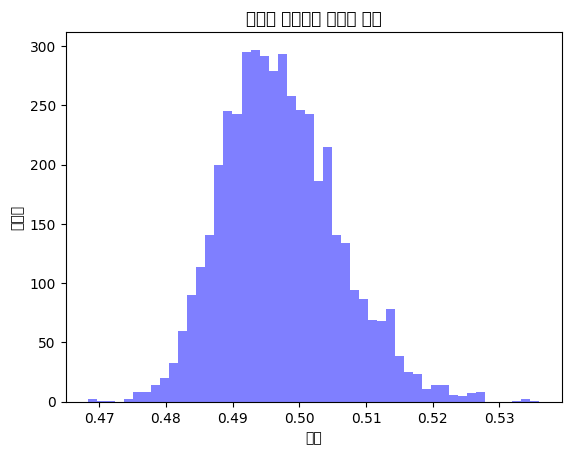

In [ ]:
import matplotlib.pyplot as plt

# 히스토그램 생성
plt.hist(df['제목_감정분석확률'], bins=50, alpha=0.5, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('제목의 감정분석 확률의 분포')
plt.xlabel('확률')
plt.ylabel('빈도수')

# 그래프 보여주기
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# '감정분석확률' 컬럼을 scaling. fit_transform은 2차원 배열을 기대하기 때문에 reshape(-1, 1)을 사용
df['제목_보정된_감정분석확률'] = scaler.fit_transform(df['제목_감정분석확률'].values.reshape(-1, 1))

# 결과 확인
df.head()

,제목,게시일,본문,제목_감정분석결과,제목_감정분석확률,제목_보정된_감정분석확률,감정레이블
0,만원 임박한 에코프로 다음 황제주 후보는 누구,2023-07-15,삼성바이오로직스 목표주가 만원 가장 유력 일 서울 중구 하나은행 딜링룸 직원 모니터...,0,0.493690,0.374973,중립
1,에코프로도 당했다 미즈호 등 불법 공매도 무더기 적발,2023-07-14,주식 빌리지 않고 선매도 하는 무차입 공매도 혐의 회사측 고의 없었다 착오였다 과징...,0,0.492552,0.358136,중립
2,에코프로 무한질주에 증권가 곤혹 에코프로비엠은 더 올라,2023-07-14,지난 일 오후 서울 종로구 연합인포맥스 스크린에 에코프로 차트가 띄워져 있다 코스...,0,0.487930,0.289767,약한 부정
3,하림지주 에코프로 등 상반기 주식관련사채 행사액 조 억,2023-07-14,한국예탁결제원은 올해 상반기 전환사채 교환사채 신주인수권부사채 등 주식관련사채 행...,0,0.491419,0.341372,약한 부정
4,에코프로 포항에 조 투자 양극재 허브 구축,2023-07-13,에코프로가 포항시 남구 블루밸리 국가산업단지에 양극소재 생태계 조성을 위해 조원을...,1,0.509288,0.605719,중립


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

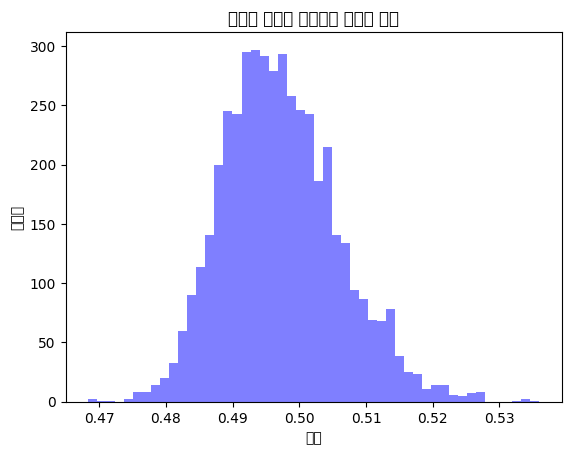

In [ ]:
# 히스토그램 생성
plt.hist(df['제목_감정분석확률'], bins=50, alpha=0.5, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('보정된 제목의 감정분석 확률의 분포')
plt.xlabel('확률')
plt.ylabel('빈도수')

# 그래프 보여주기
plt.show()

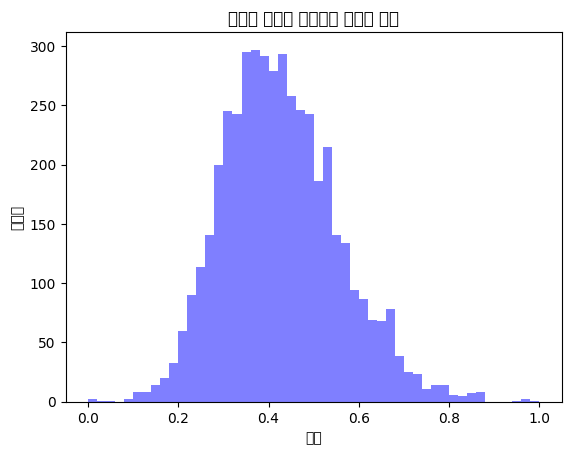

In [ ]:

# 히스토그램 생성
plt.hist(df['제목_보정된_감정분석확률'], bins=50, alpha=0.5, color='blue')

# 그래프 제목과 축 레이블 설정
plt.title('보정된 제목의 감정분석 확률의 분포')
plt.xlabel('확률')
plt.ylabel('빈도수')

# 그래프 보여주기
plt.show()

In [ ]:
def assign_label(value):
    if value <= 0.15:
        return '강한 부정'
    elif value <= 0.35:
        return '약한 부정'
    elif value <= 0.65:
        return '중립'
    elif value <= 0.85:
        return '약한 긍정'
    else:
        return '강한 긍정'

df['감정레이블'] = df['제목_보정된_감정분석확률'].apply(assign_label)


df.head()


,제목,게시일,본문,제목_감정분석결과,제목_감정분석확률,제목_보정된_감정분석확률,감정레이블
0,만원 임박한 에코프로 다음 황제주 후보는 누구,2023-07-15,삼성바이오로직스 목표주가 만원 가장 유력 일 서울 중구 하나은행 딜링룸 직원 모니터...,0,0.493690,0.374973,중립
1,에코프로도 당했다 미즈호 등 불법 공매도 무더기 적발,2023-07-14,주식 빌리지 않고 선매도 하는 무차입 공매도 혐의 회사측 고의 없었다 착오였다 과징...,0,0.492552,0.358136,중립
2,에코프로 무한질주에 증권가 곤혹 에코프로비엠은 더 올라,2023-07-14,지난 일 오후 서울 종로구 연합인포맥스 스크린에 에코프로 차트가 띄워져 있다 코스...,0,0.487930,0.289767,약한 부정
3,하림지주 에코프로 등 상반기 주식관련사채 행사액 조 억,2023-07-14,한국예탁결제원은 올해 상반기 전환사채 교환사채 신주인수권부사채 등 주식관련사채 행...,0,0.491419,0.341372,약한 부정
4,에코프로 포항에 조 투자 양극재 허브 구축,2023-07-13,에코프로가 포항시 남구 블루밸리 국가산업단지에 양극소재 생태계 조성을 위해 조원을...,1,0.509288,0.605719,중립


In [ ]:
emotion_label_counts = df['감정레이블'].value_counts()

print(emotion_label_counts)

중립       3015
약한 부정    1294
약한 긍정     261
강한 부정      29
강한 긍정      14
Name: 감정레이블, dtype: int64
